# Исследование для интернет-магазина


Целью данной работы является:

1) Изучение воронки продаж;

2) Принятие решения по результатам А/В-теста.

Задачи: 

1) Узнать как пользователи доходят до покупки;

2) Выяснить сколько пользователей доходит до покупки, а сколько —«застревает» на предыдущих шагах;

3) Исследовать результаты А/В - теста;

4) Установить какой шрифт лучше.


Дан файл с логами.

# Изучение общей информации

Загрузим полученные данные:

In [1]:
# Подключим библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = '/Users/PPC/Desktop/practica/'
log = pd.read_csv(path + 'logs_exp.csv', sep = '\t')
#log.tail(10)
#log.head(10)
log.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
166257,MainScreenAppear,5656270312181232590,1565020704,246
184650,OffersScreenAppear,3302844784932242826,1565077741,246
70643,CartScreenAppear,3041190028136719639,1564772719,247
73685,PaymentScreenSuccessful,1989685320445148348,1564780012,247
160889,CartScreenAppear,7814711012862294079,1565014051,248
35696,MainScreenAppear,2709220656435554465,1564687183,247
202712,PaymentScreenSuccessful,3046756312075882766,1565107756,247
180460,MainScreenAppear,3881814466361668142,1565069409,246
141047,MainScreenAppear,5801359697252720810,1564963214,247
196740,MainScreenAppear,322524090617972653,1565099901,247


Посмотрим на общую информацию о файле:

In [2]:
log.info()
log.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

Описание данных:

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Датафрейм log состоит из 244126 строк и 4 столбцов.

Столбец EventName содержит категориальную переменную, остальные количественную.

Пропущенные значения отсутствуют.

В столбце 'EventTimestamp' время и дата представлены в формате unix-time - нужно перевести в привычный для нас формат.

А также преобразовать названия столбцов для того, чтобы удобно было с ними работать.

# Вывод:

Каждая строка датафрейма log содержит информацию об одном действий пользователя или событий, а также: уникальный идентификатор пользователя, дату и время, название события (действия) и номер эксперимента (246 и 247 — контрольные группы (со старыми шрифтами), а 248 — экспериментальная (с измененным шрифтом)).

# Предобработка данных

1) Произведем замену типа данных в названиях столбцов на более понятные, чтобы было ясно какая информация хранится в каждом из них. Данное действие облегчит в последствии работу при обращении к конкретному столбцу:

EventName на event_name; DeviceIDHash на user_id; EventTimestamp на event_time; ExpId на exp_id.

2) Переведем время и дату в датафрейме из формата unix-time(количество секунд, прошедших с 00:00:00 1 января 1970г.) в привычное для нас.

3) Проверим датафрейм на наличие дублирующихся строк. И удалим их.

4) Добавим столбец 'event_date' с датой, в которую произошло событие.


Для преобразований в названиях столбцов воспользуемся методом rename():

In [3]:
# Создадим словарь с заменами:
columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time', 'ExpId': 'exp_id'}
# Применим к датафрейму метод rename() и перезапишем данные
log = log.rename(columns = columns)
# Проверим результат:
log.head(5)

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Для преобразования секунд(10 цифр в ячейках столбца) в читаемый вид используем метод pd.to_datetime() с параметром unit='s':

In [4]:
log['event_time_new'] = pd.to_datetime(log['event_time'],unit='s')
# Выведем на экран два столбца: начальный и измененный:
log[['event_time', 'event_time_new']].head(5)

,event_time,event_time_new
0,1564029816,2019-07-25 04:43:36
1,1564053102,2019-07-25 11:11:42
2,1564054127,2019-07-25 11:28:47
3,1564054127,2019-07-25 11:28:47
4,1564055322,2019-07-25 11:48:42


Проверим тип данных в созданном столбце 'event_time_new'. Он должен иметь тип даты и времени.

In [5]:
log.dtypes

event_name                object
user_id                    int64
event_time                 int64
exp_id                     int64
event_time_new    datetime64[ns]
dtype: object

event_time_new имеет нужный тип данных. В дальнейшем сможем работать с датой и временем.

Вычислим сколько в датафрейме полностью дублирующихся строк:

In [6]:
# Вычислим количество дубликатов:
duplicated_count = log.duplicated().sum()
# Вычислим отношение дубликатов к общему числу строк:
percent = (log.duplicated().sum() / len(log))
# Результат выведем на экран:
print('Количество дублирующихся строк: {}'.format(duplicated_count))
print('Процент от общего числа составляет: {:.2%}'.format(percent))

Количество дублирующихся строк: 413
Процент от общего числа составляет: 0.17%


Дублирующие строки составляют 0.17% от общего числа строк. Удалим их:

In [7]:
log = log.drop_duplicates().reset_index(drop = True)
# Проверим количество строк:
log.shape[0]

243713

Дубликаты удалены. В таблице осталось 243713 строк.

Добавим к датафрейму столбец, содержащий дату события:

In [8]:
# Воспользуемся методом dt.strftime():
from datetime import date 
log['event_date'] = log['event_time_new'].dt.strftime('%Y-%m-%d')
log.head(5)

,event_name,user_id,event_time,exp_id,event_time_new,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


# Вывод:

Преобразования выполнены в датафрейме: все даты имеют привычный для нас вид; создан столбец 'event_date', который содержит дату(без времени) когда произошло событие; удалены дубликаты; названия в столбцах преобразованы.

Переходим к расчетам.

# Расчеты

1. Ответим на вопрос: сколько всего событий в логе?

Каждая строчка в таблице - это индивидуальное событие.  Так как мы будем строить продуктовую воронку, важно каждое из них. Агрегировать данные не будем. Поэтому количество событий равно количеству строк в датафрейме, т.е. 243713:

In [9]:
event_count = len(log)
print('Количество событий в логе равно {}'.format(event_count))

Количество событий в логе равно 243713


2. Для того, чтобы ответить на вопрос: сколько всего пользователей в логе - вычислим количество уникальных пользователей:

In [10]:
# Обратимся к данным столбца user_id и применим метод nunique():
user_count = log['user_id'].nunique()
print('Количество пользователей в логе равно {}'.format(user_count))

Количество пользователей в логе равно 7551


В логе события по 7551 уникальному пользователю.

3. Ответим на вопрос: сколько в среднем событий приходится на пользователя? 

Для этого посмотрим на распределение данных: для каждого пользователя найдем общее количество событий: 

In [11]:
# Сгруппируем данные по 'user_id' и вычислим количество 'event_name'. Данные сохраним в переменной user_event:
user_event = log.groupby('user_id')['event_name'].count().reset_index()
# Выведем первые пять строчек датафрейма:
user_event.head(5)

,user_id,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


Выведем на экран общую статистику:

In [12]:
user_event['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Значение медианы ~ 20. Значение среднего ~ 32. Это значит, что распределение имеет положительную ассиметрию: данные скошены вправо и имеется длинный хвост высоких значений. Возможно, есть выбросы, которые и смещают среднее. Есть пользователь, у которого  количество событий ~2307.

Построим гистограмму:

In [13]:
# Зададим стиль для всех графиков:
plt.style.use('ggplot')

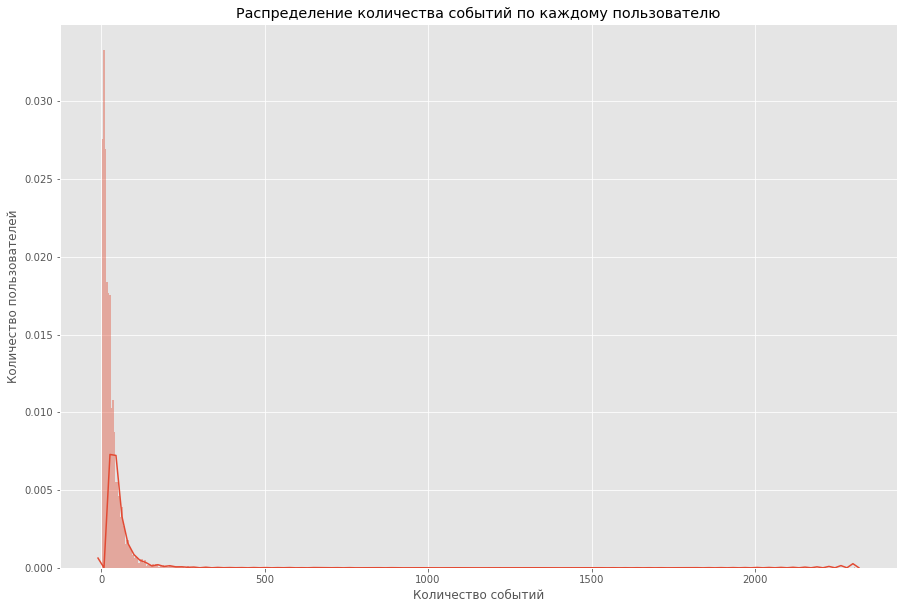

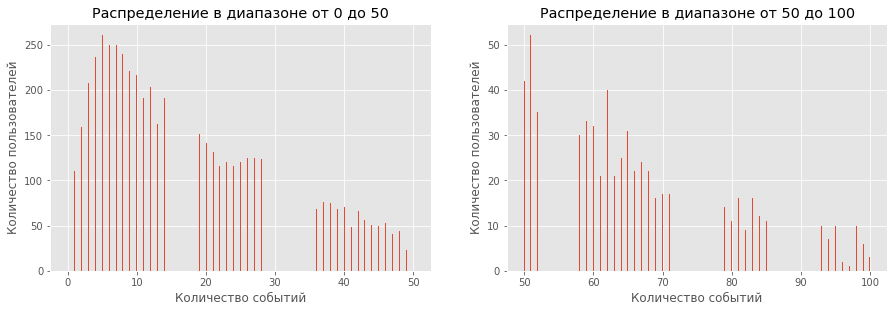

In [14]:
plt.figure(figsize = (15,10))
sns.distplot(user_event['event_name'], bins = 493)
plt.title('Распределение количества событий по каждому пользователю')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

# Построим различные диапазоны, в которых находится распределение:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
user_event['event_name'].hist(bins = 493, range = (0,50))
plt.title('Распределение в диапазоне от 0 до 50')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.subplot(2,2,2)
user_event['event_name'].hist(bins = 493, range = (50,100))
plt.title('Распределение в диапазоне от 50 до 100')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

### Вывод:

На гистограмме видно, что больше всего пользователей ~ 260 имеют количество событий ~ 5.

Медианное количество событий на одного пользователя ~ 20. 



4. Ответим на вопрос: данными за какой период располагаем? 

Выведем на экран максимальную и минимальную даты событий:

In [15]:
log['event_date'].agg({'max', 'min'})

min    2019-07-25
max    2019-08-07
Name: event_date, dtype: object

В логах события с 25 июля 2019 по 07 августа 2019гг. 

Построим гистограмму:

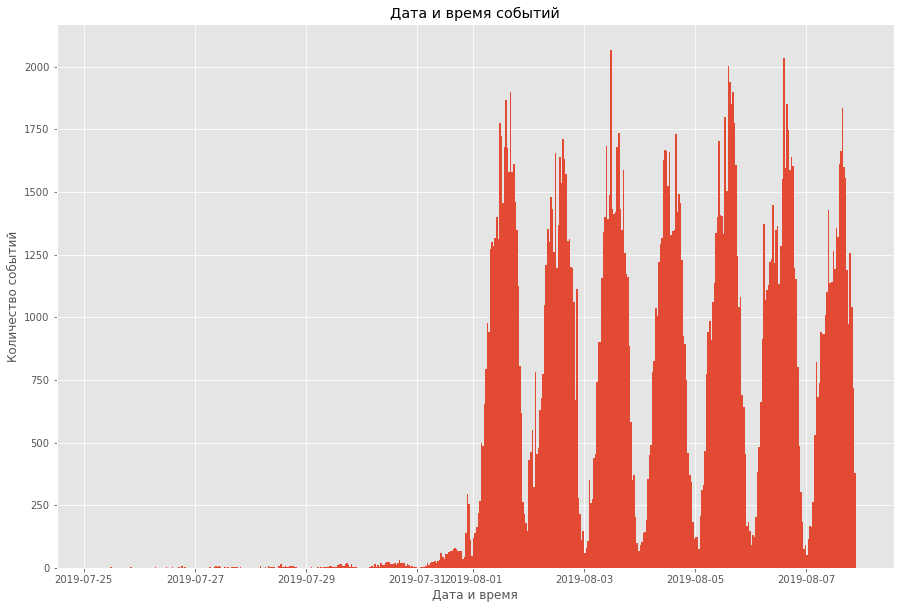

In [16]:
plt.figure(figsize = (15,10))
log['event_time_new'].hist(bins = 493)
plt.title('Дата и время событий')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.show()

На гистограмме видно, что по 31.07.2019г. включительно события редкие и их мало, а вот с 01.08.2019г. и в последующие дни форма столбцов почти одинакова, событий становится много. Данные становятся полными.


Отбросим данные до 01.08.2019г.:

In [17]:
# Создадим датафрейм log_new, 
# в котором будет храниться информация с 01 августа 2019 по 07 августа 2019гг. включительно:
log_new = log[log['event_date'] >= '2019-08-01'].reset_index(drop = True)
log_new.tail(5)

,event_name,user_id,event_time,exp_id,event_time_new,event_date
240882,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
240886,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


Будем считать, что  располагаем данными с 01 августа 2019 по 07 августа 2019гг. включительно.


5. Выясним много ли событий и пользователей потеряли, отбросив данные до 01.08.2019г.

Выведем на экран количество удаленных строк из первого датафрейма log:

In [18]:
# Вычислим количество удаленных строк:
line_count = log[log['event_date'] < '2019-08-01']['event_name'].count()
# Вычислим долю удаленых строк от общего числа в датафрейме:
percent = line_count / len(log)
print('Количество удаленных строк: {}'.format(line_count))
print('Процент: {:.2%}'.format(percent))

Количество удаленных строк: 2826
Процент: 1.16%


Выведем на экран количество уникальных пользователей, события по которым отбросили:

In [19]:
user_count = log[log['event_date'] < '2019-08-01']['user_id'].nunique()
print('Количество уникальных пользователей: {}'.format(user_count))

Количество уникальных пользователей: 1451


Сохраним уникальный идентификатор пользователя, события по которым отбросили в список. И затем проверим встречаются ли эти идентификаторы в полном списке:

In [20]:
# Отфильтруем строки в датафрейме log по условию : дата события < '2019-08-01',
# И сохраним в переменную user_unique только  уникальный идентификатор пользователя:
user_unique = list(log[log['event_date'] < '2019-08-01']['user_id'].unique())

In [21]:
# Сортируем строки датафрейма с полными датами log_new по условию (user_unique) == True
# И считаем количество уникальных пользователей:
user_nunique = log_new[log_new['user_id'].isin(user_unique) == True]['user_id'].nunique()
user_nunique

1434

Количество уникальных пользователей в неполных данных(за период до 01.08.2019г.): 1451, из них данные по 1434 пользователям попадают в период с 01 августа 2019 по 07 августа 2019гг. включительно. И если учесть, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого - мы "потеряли"  17 уникальных пользователей и некоторые события, выполненные ими.

6. Проверим, что в датафрейме log_new есть пользователи из всех трёх экспериментальных групп.

Сгруппируем данные по экспериментальной группе и в каждой вычислим количество уникальных пользователей:

In [22]:
log_new.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

В каждой экспериментальной группе присутствует приблизительно одинаковое количество уникальных пользователей ~ 2500.

# Изучение воронки событий

1. Проверим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

Выведем на экран названия событий: 

In [23]:
log_new['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

5 событий.

Вычислим сколько раз наступило каждое событие:

In [24]:
# Сгруппируем данные log_new по названию событий и вычислим количество каждого из них
event_name_count = log_new.groupby('event_name').agg({'event_name': 'count'})\
# Переименуем столбец с количеством для понимания хранимой информации:
event_name_count = event_name_count.rename(columns = ({'event_name': 'event_count'}))
event_name_count = event_name_count.sort_values(by = 'event_count', ascending = False).reset_index()

# Создадим функцию, которая будет форматировать таблицу (для наглядности):
def color_table(data):
    data =  data.style.set_properties(**{'background-color': 'moccasin',
                                        'color': 'black',
                                        'border-width': '1px',
                                        'border-style': 'solid'})
    return data
    
    
# К датафрейму  event_name_count применим функцию:   
color_table(event_name_count)

,event_name,event_count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Cобытие 'MainScreenAppear' встречается чаще всего ~ 117328 раз, а реже всех - 'Tutorial' ~ 1005.

2. Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [25]:
# сгруппируем данные по событию и найдем количество уникальных пользователей:
user_count = log_new.groupby('event_name').agg({'user_id' : 'nunique'})\
             .sort_values(by = 'user_id', ascending = False).reset_index()
# Переименуем столбец с количеством для понимания хранимой информации:
user_count = user_count.rename(columns = ({'user_id': 'user_count'}))
# К датафрейму  event_name_count применим функцию:
color_table(user_count)

,event_name,user_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Больше всех пользователей совершали событие 'MainScreenAppear' ~ 7419; меньше всех - 'Tutorial' ~ 840.

3. Посчитаем долю пользователей, которые хоть раз совершали событие:

найдем отношение (количество уникальных пользователей в событии / к общему числу уникальных пользователей). Результат выведем в %.

In [26]:
# Находим общее число уникальных пользователей в датафрейме:
user_summa = log_new['user_id'].nunique()
# Добавляем новый столбец, в который сохраняем отношение количества уникальных пользователей по каждому событию 
# к общему числу уник.пользователей:
user_count['share_user'] = (user_count['user_count'] / user_summa)


user_count.style.format({'share_user': '{:.2%}'}).set_properties(**{'background-color': 'moccasin',
                                        'color': 'black',
                                        'border-width': '1px',
                                        'border-style': 'solid'})


,event_name,user_count,share_user
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


~ 98% уник.пользователей  хоть раз совершали событие MainScreenAppear; ~ 61% - OffersScreenAppear; ~50% - CartScreenAppear; ~47% - PaymentScreenSuccessful 	и ~11% - Tutorial. До покупки доходит ~47% пользователей.

4. Предположим, в каком порядке происходят события. 

Обозначим события следующим образом:

А: MainScreenAppear - главная страница

B: OffersScreenAppear - переход в каталог

C: CartScreenAppear - корзина

D: PaymentScreenSuccessful - оплата

F: Tutorial - руководство

События происходят в следующем порядке:

A ---> B ---> C ---> D, или, A ---> F



5. По воронке событий: A ---> B ---> C ---> D посчитаем, какая доля пользователей
проходит на следующий шаг воронки (от числа пользователей на
предыдущем)

Исключим из датафрейма log_new событие Tutorial, т.к. оно не входит в последовательность действий пользователя:

In [27]:
log_new_tutorial_no = log_new[log_new['event_name'] != 'Tutorial'].copy()

По каждому пользователю найдем время когда впервые было совершено определенноее событие. Создадим сводную таблицу:

In [28]:
users = log_new_tutorial_no.pivot_table(index = 'user_id',
                           columns = 'event_name',
                           values = 'event_time_new',
                           aggfunc = 'min')
users.head(5)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


Узнаем сколько пользователей переходило с этапа на этап:

Шаг1. Сохраняем события 'MainScreenAppear' без пропусков: первое обращение в приложение.

Шаг2. Сохраняем события 'OffersScreenAppear', которые произошли позднее 'MainScreenAppear' и есть первое обращение в приложение.

Шаг3. Сохраняем события 'CartScreenAppear', которые произошли позднее 'OffersScreenAppear' + шаг2.

Шаг4. Сохраняем события 'PaymentScreenSuccessful', которые произошли позднее 'CartScreenAppear' + шаг3.

В результате получим воронку событий.

In [29]:
# Шаг1:
step_1 = ~users['MainScreenAppear'].isna()
# Шаг2:
step_2 = step_1&(users['OffersScreenAppear'] > users['MainScreenAppear'])
# Шаг3:
step_3 = step_2&(users['CartScreenAppear'] > users['OffersScreenAppear'])
# Шаг4:
step_4 = step_3&(users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

# Находим количество пользователей в каждом шаге:
MainScreenAppear_count = users[step_1].shape[0]
OffersScreenAppear_count = users[step_2].shape[0]
CartScreenAppear_count = users[step_3].shape[0]
PaymentScreenSuccessful_count = users[step_4].shape[0]

# Результат сохраняем в датафрейм:
result = pd.DataFrame()
result['event_name'] = pd.Series(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', \
                                  'PaymentScreenSuccessful'])
result['user_count'] = pd.Series([MainScreenAppear_count, OffersScreenAppear_count, CartScreenAppear_count, \
                                  PaymentScreenSuccessful_count])
result

,event_name,user_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4201
2,CartScreenAppear,1767
3,PaymentScreenSuccessful,454


Вычислим долю пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем):

In [30]:
# Создаем столбец user_count_new, в котором сохраняем количество пользователей на предыдущем шаге:
# Применяем к значениям user_count метод shift():
result['user_count_new'] = result['user_count'].shift()
# В первой ячейке нового столбца пропуск, т.к. значение 0 ячейки сдвинулось с шагом 1 вниз.
# Заменяем пропуск на значение, которое было сдвинуто:
result['user_count_new'] = result['user_count_new'].fillna(result['user_count'])
# Находим долю пользователей: user_count / user_count_new:
result['share_user'] = result['user_count'] / result['user_count_new']
# Форматируем значения в столбцах user_count_new и share_user. Накладываем тепловую карту на результат для наглядности 
result = result.style.format({'user_count_new': '{:.0f}', 'share_user': '{:.2%}'.format})\
        .background_gradient(cmap='coolwarm')

Визуализируем полученные данные - построим воронку последовательности событий:

In [31]:

from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

voronka = (go.Funnel(
        y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
        x = [MainScreenAppear_count, OffersScreenAppear_count, CartScreenAppear_count, PaymentScreenSuccessful_count],
        textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
)
layout = go.Layout(
    title='Воронка последовательности событий(от числа пользователей на предыдущем)'
)
fig = go.Figure(data = [voronka], layout = layout)
fig.show(renderer='iframe')

In [32]:
print("Доля пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем):")
result

Доля пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем):


,event_name,user_count,user_count_new,share_user
0,MainScreenAppear,7419,7419,100.00%
1,OffersScreenAppear,4201,7419,56.62%
2,CartScreenAppear,1767,4201,42.06%
3,PaymentScreenSuccessful,454,1767,25.69%


### Вывод:


C MainScreenAppear на OffersScreenAppear 	перешло 56.6% пользователей(потеряно - 43.38%);

с OffersScreenAppear на CartScreenAppear перешло 42.06%(по сравнению с предыдущим шагом потеряно - 14.56%);

с CartScreenAppear на PaymentScreenSuccessful перешло 25.69%(по сравнению с предыдущим шагом потеряно - 16.37%).

На каждом шаге теряем пользователей. Но больше всего потеряно пользователей ~ 43.38% с перехода с первого на второй шаг: с MainScreenAppear на OffersScreenAppear.

С первого до последнего шага (MainScreenAppear -->  PaymentScreenSuccessful) доходит 6% пользователей.

Сравним результаты полученных результатов из таблиц user_count(доля людей, хоть раз совершавших действие) и result(доля людей которая проходит на следующий шаг воронки событий (от числа пользователей на предыдущем)). 

In [33]:
color_table(user_count)

,event_name,user_count,share_user
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


In [34]:
result

,event_name,user_count,user_count_new,share_user
0,MainScreenAppear,7419,7419,100.00%
1,OffersScreenAppear,4201,7419,56.62%
2,CartScreenAppear,1767,4201,42.06%
3,PaymentScreenSuccessful,454,1767,25.69%


Если сравнить результаты расчетов в столбце user_count в двух таблицах, то становится ясно, что существуют  иные пути, чтобы добраться до шага PaymentScreenSuccessful, потому что в первой талице (количество людей, хоть раз совершивших действие) количество оплативших = 3539, а во второй таблице = 454.

Количество уникальных пользователей, совершивших хоть раз событие CartScreenAppear 	= 3734, а количество людей, которые выполнили указанное действие и которые "шли" по предполагаемому пути ~ 1767.

# Изучение результатов эксперимента

1. Выведем на экран количество пользователей из каждой экспериментальной группы:

In [35]:
log_new.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

В каждой группе почти одинаковое количество пользователей ~ 2500.

246 и 247 — контрольные группы(предложены старые шрифты), а 248 — экспериментальная(предложены новые шрифты).


2. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим,
находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешности А-А теста:

1. Количество пользователей в различных группах различается не более, чем на 1%.

2. Различие ключевых метрик по группам не превышает 1% и не имеет стат.значимости.

Чтобы проверить критерий, выполним:

А) Создадим 2 датафрейма : log_new сгруппируем по 2 контрольным группам 246, 247.

В) В каждом из двух датафреймов строим воронку событий (долю пользователей, которые хоть раз совершали событие: отношение количества уникальных пользователей в событии к общему числу уникальных пользователей в группе).

С) Проверим является ли распределение количества уник.пользователей в гр.246,247 нормальным.

D) Проверим гипотезу о равенстве средних(т.о. статистически подтверждаем критерии №1)

F) Воспользуемся гипотезой о равенстве долей (Проверяем критерии №2). 


Приступим:


А) Отфильтруем данные по соответствующей группе и сохраним в переменную:

In [36]:
# Фильтруем строки датафрейма log_new по exp_id == "246"
log_246 = log_new.query('exp_id == "246"').copy()
# Фильтруем строки датафрейма log_new по exp_id == "247"
log_247 = log_new.query('exp_id == "247"').copy()


B) Строим воронку событий для каждой группы:

In [37]:
# Для 246: 
# Группируем данные по событию, находим количество уник.польз., сортируем по убыванию:
rezults_246 = log_246.groupby('event_name').agg({'user_id': 'nunique'})\
.sort_values(by = 'user_id', ascending = False).reset_index()
# Добавляем столбец с общим количеством уник.пользователей в группе:
rezults_246['user_id_uniq'] = log_246['user_id'].nunique()
# Находим долю пользователей от общего числа уник. пользователей в группе, 
# результат сохраняем в новый столбец и округляем его до 2 знаков после запятой:
rezults_246['share_user'] = round(rezults_246['user_id'] / rezults_246['user_id_uniq'], 2)
# Переименуем названия столбцов для ясности:
rezults_246 = rezults_246\
.rename(columns = ({'user_id': 'user_id_246', 'user_id_uniq': 'user_id_uniq_246', 'share_user': 'share_user_246'}))


# Для 247: делаем аналогично 246
rezults_247 = log_247.groupby('event_name').agg({'user_id': 'nunique'})\
.sort_values(by = 'user_id', ascending = False).reset_index()
rezults_247['user_id_uniq'] = log_247['user_id'].nunique()
rezults_247['share_user'] = round(rezults_247['user_id'] / rezults_247['user_id_uniq'], 2)
rezults_247 = rezults_247\
.rename(columns = ({'user_id': 'user_id_247', 'user_id_uniq': 'user_id_uniq_247', 'share_user': 'share_user_247'}))
# Выводим результат на экран:
print(rezults_246)
print('-------------------')
print(rezults_247)

                event_name  user_id_246  user_id_uniq_246  share_user_246
0         MainScreenAppear         2450              2484            0.99
1       OffersScreenAppear         1542              2484            0.62
2         CartScreenAppear         1266              2484            0.51
3  PaymentScreenSuccessful         1200              2484            0.48
4                 Tutorial          278              2484            0.11
-------------------
                event_name  user_id_247  user_id_uniq_247  share_user_247
0         MainScreenAppear         2476              2513            0.99
1       OffersScreenAppear         1520              2513            0.60
2         CartScreenAppear         1238              2513            0.49
3  PaymentScreenSuccessful         1158              2513            0.46
4                 Tutorial          283              2513            0.11


Объединим датафреймы rezults_246 и rezults_247 в один:

In [38]:
# Применим метод merge():
total_246_247 = rezults_246.merge(rezults_247)
total_246_247

,event_name,user_id_246,user_id_uniq_246,share_user_246,user_id_247,user_id_uniq_247,share_user_247
0,MainScreenAppear,2450,2484,0.99,2476,2513,0.99
1,OffersScreenAppear,1542,2484,0.62,1520,2513,0.60
2,CartScreenAppear,1266,2484,0.51,1238,2513,0.49
3,PaymentScreenSuccessful,1200,2484,0.48,1158,2513,0.46
4,Tutorial,278,2484,0.11,283,2513,0.11


С)  Проверим является ли распределение количества уник.пользователей в гр.246,247 нормальным.

Построим Q-Q plot:

In [39]:
# Добавим столбец в датафреймах, в котором дата округлена до часа:
log_246['time_routed'] = log_246['event_time_new'].dt.round('1H')
log_247['time_routed'] = log_247['event_time_new'].dt.round('1H')

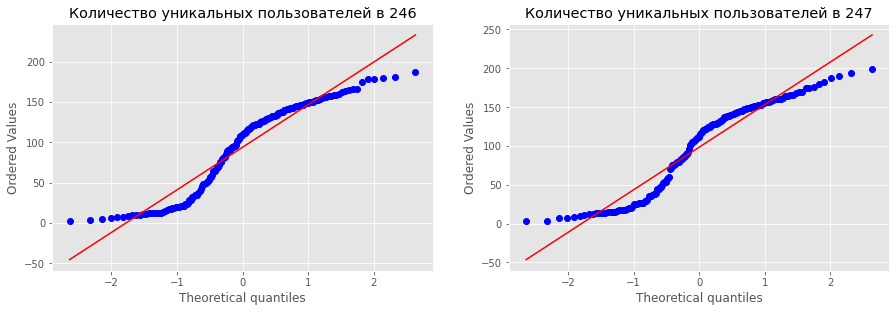

In [40]:
from scipy import stats 
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
# Группируем данные гр.246 по столбцу с округленной датой до часа и вычисляем количество уник. пользователей в час за каждый день:
# Строим Q-Q plot:
stats.probplot(log_246.groupby('time_routed')['user_id'].nunique() ,plot = plt)
plt.title('Количество уникальных пользователей в 246')
plt.subplot(2,2,2)
# Группируем данные гр.247 по столбцу с округленной датой до часа и вычисляем количество уник. пользователей в час за каждый день:
# Строим Q-Q plot:
stats.probplot(log_247.groupby('time_routed')['user_id'].nunique() ,plot = plt)
plt.title('Количество уникальных пользователей в 247')
plt.show()

Выборки количества уникальных пользователей в группах 246 и 247 распределены не нормально:  видим, что на двух графиках по правую сторону от 0 (0 - середина распределения) точки сначала уползают вверх от прямой линий, а затем сильно отклоняются вниз. При этом с левой стороны все точки сначала сильно уходят вниз, а затем вверх.

Подтвердим полученный вывод с помощью теста Шапиро:

Сформулируем нулевую гипотезу: распределения значимо не отличаются от нормального.

Альтернативную: распределения значимо отличаются от нормального.

Критический уровень значимости: 0.05.

In [41]:
# Используем метод st.shapiro():
from scipy import stats as st
alpha = .05
results = st.shapiro(log_246.groupby('time_routed')['user_id'].nunique())
p_value = results[1]
print('p-значение:', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

    

p-значение: 2.6383789375472588e-08
Отвергаем нулевую гипотезу: распределение не нормально


p-значение: 2.6383789375472588e-08 < 0.05, поэтому отклоняем нулевую гипотезу. И предполагаем, что  распределение значимо отличается от нормального.

Применяем тест для распределения количества уник.пользователей гр.247:

In [42]:
alpha = .05
results = st.shapiro(log_247.groupby('time_routed')['user_id'].nunique())
p_value = results[1]
print('p-значение:', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение: 3.6822800808522516e-08
Отвергаем нулевую гипотезу: распределение не нормально


p-значение: 3.6822800808522516e-08 < 0.05, поэтому отклоняем нулевую гипотезу. И предполагаем, что  распределение значимо отличается от нормального.

Величина количества уникальных пользователей в двух группах распределена не нормально. 

D. Проверим гипотезу о равенстве средних: 

Так как распределения мультимодальные, применим для проверки Z-тест:

statsmodels.stats.proportion.proportions_ztest(a_users, all_participants, value = 0.5), 

где a_users - количество уникальных пользователей в группе А (число), all_participants - количество всех уникальных участников теста (число),  value  - ожидаемый уровень (мы ожидаем, что пользователи в группе А составят 50%).

Учтем, что группа А = группе 246. 

Нулевая гипотеза: средние значения в двух группах не отличаются.

Альтернативная гипотеза: есть значимые различия между средними значениями двух групп.

Критический уровень значимости: 0.05.

In [43]:
# Вычислим число уникальных пользователей в группе 246, 247 и найдем их сумму:
group_246 = log_new.query('exp_id == "246"')['user_id'].nunique()
group_247 = log_new.query('exp_id == "247"')['user_id'].nunique()
group_246_247 = group_246 + group_247
print('Количество уникальных пользователей в группе 246:', group_246)
print('Количество уникальных пользователей в группе 247:', group_247)
print('Общее количество уникальных пользователей в групах 246 и 247:', group_246_247)

Количество уникальных пользователей в группе 246: 2484
Количество уникальных пользователей в группе 247: 2513
Общее количество уникальных пользователей в групах 246 и 247: 4997


Применим statsmodels.stats.proportion.proportions_ztest(a_users, all_participants, value = 0.5):

In [44]:
from statsmodels.stats.proportion import proportions_ztest
alpha = .05

stat, pval = proportions_ztest(2484, 4997, value = 0.5)
print('p-значение:', pval)

if(pval < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя')



p-значение: 0.6816211476613262
Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя


p-значение: 0.6816211476613262 > 0.05, поэтому не получилось отвергнуть нулевую гипотезу. 

Предполагаем, что различий в группах нет. 

А это значит, что подтвержден критерии №1: количество пользователей в группах 246 и 247 значимо не различается.

F) Проверяем критерий №2: различие ключевых метрик по группам не превышает 1% и не имеет стат.значимости.

Ключевые метрики - доли в воронке событий, т.е. отношение количества уник.пользователей в событии к общему числу уникальных пользователей.

Дано две группы 246 и 247.

В каждой группе следующие события: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial и также для каждого события известна доля количества уникальных пользователей от общего числа уник.пользователей в группе.

Воспользуемся гипотезой о равенстве долей.

Сформулируем нулевую гипотезу: доля пользователей в каждом из событии группы 246 не отличается от доли пользователей в соответствующем событии группы 247.

Альтернативная гипотеза: Доли в соответствующих событиях различны.

Критический уровень значимости: 0.05.

Наши действия:

1. Создаем функцию proportion_test(argument_1:list, argument_2:list), с помощью которой будем определять есть статистическая значимость между ключевыми метриками по группам или нет. В качестве аргумента будем передавать два списка:

argument_1 = [Х, У], 
argument_2 = [Z, T]

(Х - количество уникальных пользователей в событий гр.246, Y - в соответствующей группе 247; Z - Общее количество уник.пользователей в гр.246, Т - Общее количество уник.пользователей в гр.247)

В теле функции пропишем метод proportions_ztest(argument_1, argument_2), который будет рассчитывать pvalue.

Приступим: выведем на экран датафрейм total_246_247:

In [45]:
total_246_247

,event_name,user_id_246,user_id_uniq_246,share_user_246,user_id_247,user_id_uniq_247,share_user_247
0,MainScreenAppear,2450,2484,0.99,2476,2513,0.99
1,OffersScreenAppear,1542,2484,0.62,1520,2513,0.60
2,CartScreenAppear,1266,2484,0.51,1238,2513,0.49
3,PaymentScreenSuccessful,1200,2484,0.48,1158,2513,0.46
4,Tutorial,278,2484,0.11,283,2513,0.11


Создадим две переменные user_id_uniq_total_246 и user_id_uniq_total_247, которые передадим в argument_2 = [Z, T]:

In [46]:
# Вычисляем количество уник.пользователей в гр.246:
user_id_uniq_total_246 = log_246['user_id'].nunique()
# Вычисляем количество уник.пользователей в гр.247:
user_id_uniq_total_247 = log_247['user_id'].nunique()
# Создаем список argument_2 = [Z, T] и передаем в него полученные данные:
argument_2 = [user_id_uniq_total_246, user_id_uniq_total_247]

Создадим столбец user_id_246_247, в котором объединим значения ячеек user_id_246 + user_id_247 (это будет argument_1 = [Х, У]):

In [47]:
# Переводим числа в строковый формат и объединяем их:
total_246_247 = total_246_247\
.assign(user_id_246_247 = total_246_247['user_id_246'].astype(str) + ', ' + total_246_247['user_id_247'].astype(str))
total_246_247

,event_name,user_id_246,user_id_uniq_246,share_user_246,user_id_247,user_id_uniq_247,share_user_247,user_id_246_247
0,MainScreenAppear,2450,2484,0.99,2476,2513,0.99,"2450, 2476"
1,OffersScreenAppear,1542,2484,0.62,1520,2513,0.60,"1542, 1520"
2,CartScreenAppear,1266,2484,0.51,1238,2513,0.49,"1266, 1238"
3,PaymentScreenSuccessful,1200,2484,0.48,1158,2513,0.46,"1200, 1158"
4,Tutorial,278,2484,0.11,283,2513,0.11,"278, 283"


Создаем функцию:

In [48]:
def proportion_test(argument_1:list, argument_2:list):
    from statsmodels.stats.proportion import proportions_ztest
    alpha = 0.05
    stat, pval = proportions_ztest(argument_1, argument_2)
    print('p-значение:', pval)
    if(pval < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    

2. Применяем функцию proportion_test к данным столбца user_id_246_247 датафрейма total_246_247:

In [49]:
# Передаем столбец в переменную:
column = total_246_247['user_id_246_247'].unique()
# Для каждой значения столбца 'user_id_246_247' датафрейма total_246_247: (на входе строка "str")
for i in column:
    i = i.split(',') # Разделим значения "str" в каждой ячейке с помощью запятой и перезапишем результат
    i = list(map(int, i)) # "str" переведем в число "int" и вернем объект список (list)
    proportion_test(i, argument_2) # Применяем функцию proportion_test(argument_1:list, argument_2:list)


p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.11456679313141847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех случаях получили pvalue > 0.05. Поэтому у нас нет оснований, чтобы отвергнуть нулевую гипотезу.  Предполагаем, что доля пользователей в каждом из событии группы 246 не отличается от доли пользователей в соответствующем событии группы 247. А это значит, мы проверили критерии №2: различие ключевых метрик по группам не имеет стат.значимости.

### Вывод: 



Было установлено, что: 

1) различие ключевых метрик групп 246 и 247 не имеет статистической значимости.

2) количество уникальных пользователей двух групп не имеет значимых различий.

Это значит, что были выполнены критерии успешности А/А - теста. Поэтому можем сказать, что разбиение на группы работает корректно.

3. Рассмотрим распределение количества уникальных пользователей в экспериментальной группе 248(в группе с измененным шрифтом):

Выполнять действия будем такие же как и для 246 и 247.


In [50]:
#Отфильтруем данные по соответствующей группе и сохраним в переменную:
log_248 = log_new.query('exp_id == "248"').copy()
#Строим воронку событий для каждой группы:
# Группируем данные по событию, находим количество уник.польз., сортируем по убыванию:
rezults_248 = log_248.groupby('event_name').agg({'user_id': 'nunique'})\
              .sort_values(by = 'user_id', ascending = False).reset_index()
# Добавляем столбец с общим количеством уник.пользователей в группе:
rezults_248['user_id_uniq'] = log_248['user_id'].nunique()
# Находим долю пользователей от общего числа уник. пользователей в группе, результат сохраняем в новый столбец
# И округляем его до 2 знаков после запятой:
rezults_248['share_user'] = round(rezults_248['user_id'] / rezults_248['user_id_uniq'], 2)
# Переименуем названия столбцов для ясности:
rezults_248 = rezults_248\
.rename(columns = ({'user_id': 'user_id_248', 'user_id_uniq': 'user_id_uniq_248', 'share_user': 'share_user_248'}))
# Покажем результат:
rezults_248


,event_name,user_id_248,user_id_uniq_248,share_user_248
0,MainScreenAppear,2493,2537,0.98
1,OffersScreenAppear,1531,2537,0.60
2,CartScreenAppear,1230,2537,0.48
3,PaymentScreenSuccessful,1181,2537,0.47
4,Tutorial,279,2537,0.11


Проверим является ли распределение количества уник.пользователей в гр.248 нормальным.
Построим Q-Q plot:


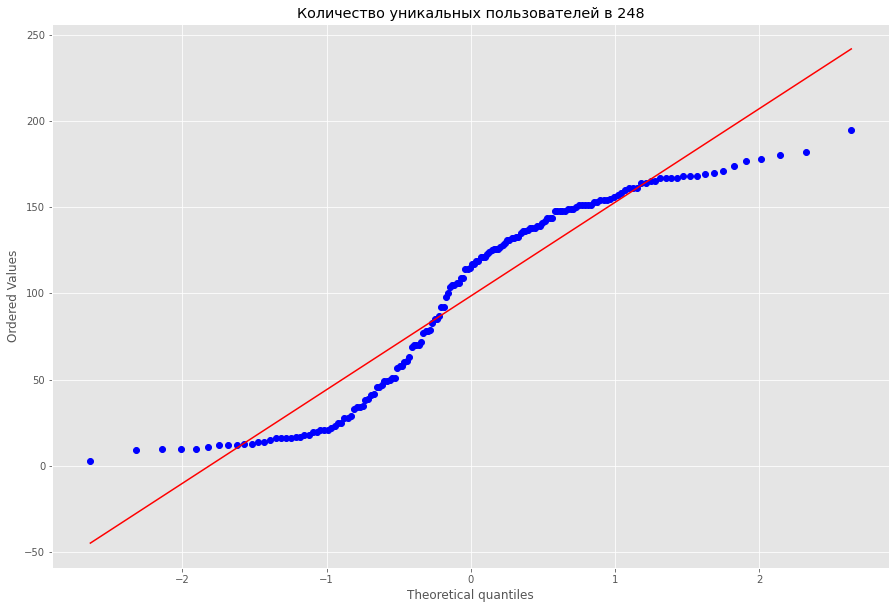

In [51]:
log_248['time_routed'] = log_248['event_time_new'].dt.round('1H')
from scipy import stats 
plt.figure(figsize = (15,10))
# Группируем данные гр.248 по столбцу с округленной датой до часа и вычисляем количество уник. пользователей в час:
# Строим Q-Q plot:
stats.probplot(log_248.groupby('time_routed')['user_id'].nunique() ,plot = plt)
plt.title('Количество уникальных пользователей в 248')
plt.show()

Выборка количества уникальных пользователей в группе 248  распределена не нормально:  видим, что  по правую сторону от 0 (0 - середина распределения) точки сначала уползают вверх от прямой линий, а затем сильно отклоняются вниз. При этом с левой стороны все точки сначала сильно уходят вниз, а затем вверх.

Подтвердим полученный вывод с помощью теста Шапиро:


In [52]:
# Используем метод st.shapiro():
from scipy import stats as st
alpha = .05
results = st.shapiro(log_248.groupby('time_routed')['user_id'].nunique())
p_value = results[1]
print('p-значение:', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')


p-значение: 7.232356491471137e-09
Отвергаем нулевую гипотезу: распределение не нормально


p-значение: 7.232356491471137e-09 < 0.05, поэтому отклоняем нулевую гипотезу. И предполагаем, что распределение значимо отличается от нормального.

Так как не было выявлено статистически значимых различий между контрольными группами 246 и 247 (при pvalue: 0.16536363787420583 > 0.05), то будем считать группы эквивалентными. 

Поэтому сравнивать 248 группу (с новым шрифтом) будем с группой 247 (со старым шрифтом): 

проверим есть ли значимые различия между количеством уникальных пользователей в группах; 

между ключевыми метриками соответствующих событий.

Соединим данные 247 и 248 группы вместе:

In [53]:
# для соединения таблиц применим merge():
total_247_248 = rezults_248.merge(rezults_247)
total_247_248

,event_name,user_id_248,user_id_uniq_248,share_user_248,user_id_247,user_id_uniq_247,share_user_247
0,MainScreenAppear,2493,2537,0.98,2476,2513,0.99
1,OffersScreenAppear,1531,2537,0.60,1520,2513,0.60
2,CartScreenAppear,1230,2537,0.48,1238,2513,0.49
3,PaymentScreenSuccessful,1181,2537,0.47,1158,2513,0.46
4,Tutorial,279,2537,0.11,283,2513,0.11


In [54]:
# Переводим числа в строковый формат и объединяем их, результат сохраняем в новом столбце:
total_247_248 = total_247_248\
.assign(user_id_247_248 = total_247_248['user_id_248'].astype(str) + ', ' + total_247_248['user_id_247'].astype(str))
total_247_248

,event_name,user_id_248,user_id_uniq_248,share_user_248,user_id_247,user_id_uniq_247,share_user_247,user_id_247_248
0,MainScreenAppear,2493,2537,0.98,2476,2513,0.99,"2493, 2476"
1,OffersScreenAppear,1531,2537,0.60,1520,2513,0.60,"1531, 1520"
2,CartScreenAppear,1230,2537,0.48,1238,2513,0.49,"1230, 1238"
3,PaymentScreenSuccessful,1181,2537,0.47,1158,2513,0.46,"1181, 1158"
4,Tutorial,279,2537,0.11,283,2513,0.11,"279, 283"


Проверяем есть ли значимые различия между количеством уникальных пользователей в группах 248 и 247. 

Распределения количества уникальных пользователей в группах 248 и 247 мультимодальные, применим для проверки Z-тест:

statsmodels.stats.proportion.proportions_ztest(a_users, all_participants, value = 0.5), 

где a_users - количество уникальных пользователей в группе А (число), all_participants - количество всех уникальных участников теста (число),  value  - ожидаемый уровень (мы ожидаем, что пользователи в группе А составят 50%).

Учтем, что группа А = группе 247. 

Нулевая гипотеза: средние значения в двух группах не отличаются.

Альтернативная гипотеза: есть значимые различия между средними значениями двух групп.

Критический уровень значимости: 0.05.



In [55]:
# Вычислим число уникальных пользователей в группе 248, 247 и найдем их сумму:
group_247 = log_new.query('exp_id == "247"')['user_id'].nunique()
group_248 = log_new.query('exp_id == "248"')['user_id'].nunique()
group_247_248 = group_247 + group_248
print('Количество уникальных пользователей в группе 247:', group_247)
print('Количество уникальных пользователей в группе 248:', group_248)
print('Общее количество уникальных пользователей в групах 247 и 248:', group_247_248)


Количество уникальных пользователей в группе 247: 2513
Количество уникальных пользователей в группе 248: 2537
Общее количество уникальных пользователей в групах 247 и 248: 5050


Применим statsmodels.stats.proportion.proportions_ztest(a_users, all_participants, value = 0.5):

In [56]:
from statsmodels.stats.proportion import proportions_ztest
alpha = .05

stat, pval = proportions_ztest(2513, 5050, value = 0.5)
print('p-значение:', pval)

if(pval < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя')


p-значение: 0.7355661860935975
Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя


p-значение: 0.7355661860935975 > 0.05, поэтому не получилось отвергнуть нулевую гипотезу.

Предполагаем, что значимых различий между количеством уникальных пользователей в группах 248 и 247 нет. 

Проверяем есть ли значимые различия между ключевыми метриками соответствующих событий: долями уникальных пользователей в событий от общего числа уник.пользователей в группе.

Воспользуемся гипотезой о равенстве долей.

Сформулируем нулевую гипотезу: доля пользователей в каждом из событии группы 248 не отличается от доли пользователей в соответствующем событии группы 247.

Альтернативная гипотеза: Доли в соответствующих событиях различны.

Критический уровень значимости: 0.05.

Применим к данным столбца user_id_247_248 датафрейма total_247_248 созданную функцию proportion_test(argument_1:list, argument_2:list)

In [57]:
# Передаем в argument_2 общее количество уник.пользователей:
argument_2 = [total_247_248['user_id_uniq_248'][0], total_247_248['user_id_uniq_247'][0]]
# Передаем данные столбеца  user_id_247_248 датафрейма total_247_248 в переменную:
column = total_247_248['user_id_247_248'].unique()
# Для каждой значения столбца 'user_id_248_247' датафрейма total_248_247: (на входе строка "str")
for i in column:
    i = i.split(',') # Разделим значения "str" в каждой ячейке с помощью запятой и перезапишем результат
    i = list(map(int, i)) # "str" переведем в число "int" и вернем объект список (list)
    proportion_test(i, argument_2) # Применяем функцию proportion_test(argument_1:list, argument_2:list)

p-значение: 0.45870536166215137
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.919781783059226
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.5786197879539782
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7653239224745011
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех случаях получили pvalue > 0.05. Поэтому у нас нет оснований, чтобы отвергнуть нулевую гипотезу.  А это значит, что значимых различий между долями пользователей в каждом из событии групп 248 и 247 нет.

4. При проверке гипотез выше был выбран критический уровень значимости: 0.05. Всего было проведено 10 проверок на сравнение долей соответствующих событий, 2 проверки на сравнение среднего количества уникальных пользователей в двух группах А/В - теста и А/А-теста. И 3 теста Шапиро. Получается на одних и тех же данных было проведено 15 проверок. Так как с каждой новой проверкой гипотезы растет вероятность ошибки первого рода -  применим к критическому уровню значимости поправку Бонферрони. 

Исходя из поправки Бонферрони к уровню значимости:

bonferroni_alpha = (alpha / 15) = (0.05 / 15) 

Перепроверим уже выполненные тесты  и учтем bonferroni_alpha:

In [58]:
# Вычислим bonferroni_alpha:
bonferroni_alpha = (0.05 / 15) 
print('bonferroni_alpha = ', bonferroni_alpha)

bonferroni_alpha =  0.0033333333333333335


1) Тесты Шапиро:

Проверка гипотезы о том, что распределения количества уникальных пользователей в группах 246, 247, 248 значимо отличаются от нормального:

Создадим функцию, которая будет рассчитывать p_value, в аргумент которой будем передавать соответствующее распределение:

In [59]:
def test_shapiro(data):
    # Используем метод st.shapiro():
    from scipy import stats as st
# Изменяем критический уровень значимости на bonferroni_alpha:
    alpha = .05
    bonferroni_alpha = 0.05 / 15 
    results = st.shapiro(data)
    p_value = results[1]
    print('p-значение:', p_value)
    if (p_value < bonferroni_alpha):
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

Применим функцию test_shapiro и результат выведем на экран:

In [60]:
print('Для 246:')
test_shapiro(log_246.groupby('time_routed')['user_id'].nunique())
print('Для 247:')
test_shapiro(log_247.groupby('time_routed')['user_id'].nunique())
print('Для 248:')
test_shapiro(log_248.groupby('time_routed')['user_id'].nunique())

Для 246:
p-значение: 2.6383789375472588e-08
Отвергаем нулевую гипотезу: распределение не нормально
Для 247:
p-значение: 3.6822800808522516e-08
Отвергаем нулевую гипотезу: распределение не нормально
Для 248:
p-значение: 7.232356491471137e-09
Отвергаем нулевую гипотезу: распределение не нормально


2) z-тесты на проверку о том, что средние значения в группах: а) 246 и 247; б) 247 и 248 значимо не отличаются:

Создадим функцию, которая будет рассчитывать p_value, в аргумент которой будем передавать: a_users - количество уникальных пользователей в группе А (число), all_participants - количество всех уникальных участников теста (число)

In [61]:
def test_z(a_users, all_participants):
    from statsmodels.stats.proportion import proportions_ztest
    alpha = .05
    bonferroni_alpha = 0.05 / 15

    stat, pval = proportions_ztest(a_users, all_participants, value = 0.5)
    print('p-значение:', pval)

    if(pval < bonferroni_alpha):
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя')

Применим функцию test_z и результат выведем на экран:


In [62]:
print('Для 246 и 247:')
test_z(2484, 4997)
print('Для 247 и 248:')
test_z(2513, 5050)

Для 246 и 247:
p-значение: 0.6816211476613262
Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя
Для 247 и 248:
p-значение: 0.7355661860935975
Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя


3) Проверка гипотезы о том, что доля пользователей в каждом из событии групп: а) 246 и 247; б) 247 и 248 значимо не различаются.

Создаем функцию proportion_test_bonferroni(argument_1:list, argument_2:list), с помощью которой будем определять есть статистическая значимость между долями пользователей в каждом из событии групп: а) 246 и 247; б) 247 и 248 или нет. В качестве аргумента будем передавать два списка:

argument_1 = [Х, У], argument_2 = [Z, T]

(Х - количество уникальных пользователей в событий гр.246/247, Y - в соответствующей группе 247/248; Z - Общее количество уник.пользователей в гр.246/247, Т - Общее количество уник.пользователей в гр.247/248)

В теле функции пропишем метод proportions_ztest(argument_1, argument_2), который будет рассчитывать pvalue.

In [63]:
# Принимает функция на вход в аргумент два списка:
def proportion_test_bonferroni(argument_1:list, argument_2:list):
    from statsmodels.stats.proportion import proportions_ztest
    alpha = .05
    bonferroni_alpha = 0.05 / 15
    stat, pval = proportions_ztest(argument_1, argument_2)
    print('p-значение:', pval)
    if(pval < bonferroni_alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Выведем на экран датафрейм total_246_247:

In [64]:
total_246_247

,event_name,user_id_246,user_id_uniq_246,share_user_246,user_id_247,user_id_uniq_247,share_user_247,user_id_246_247
0,MainScreenAppear,2450,2484,0.99,2476,2513,0.99,"2450, 2476"
1,OffersScreenAppear,1542,2484,0.62,1520,2513,0.60,"1542, 1520"
2,CartScreenAppear,1266,2484,0.51,1238,2513,0.49,"1266, 1238"
3,PaymentScreenSuccessful,1200,2484,0.48,1158,2513,0.46,"1200, 1158"
4,Tutorial,278,2484,0.11,283,2513,0.11,"278, 283"


Применяем функцию proportion_test_bonferroni к данным столбца user_id_246_247 датафрейма total_246_247:

In [65]:
# Передаем столбец в переменную:
argument_2 = [user_id_uniq_total_246, user_id_uniq_total_247]
column = total_246_247['user_id_246_247'].unique()
# Для каждой значения столбца 'user_id_246_247' датафрейма total_246_247: (на входе строка "str")
for i in column:
    i = i.split(',') # Разделим значения "str" в каждой ячейке с помощью запятой и перезапишем результат
    i = list(map(int, i)) # "str" переведем в число "int" и вернем объект список (list)
    proportion_test_bonferroni(i, argument_2) # Применяем функцию proportion_test(argument_1:list, argument_2:list)

p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.11456679313141847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выведем на экран датафрейм total_247_248:

In [66]:
total_247_248

,event_name,user_id_248,user_id_uniq_248,share_user_248,user_id_247,user_id_uniq_247,share_user_247,user_id_247_248
0,MainScreenAppear,2493,2537,0.98,2476,2513,0.99,"2493, 2476"
1,OffersScreenAppear,1531,2537,0.60,1520,2513,0.60,"1531, 1520"
2,CartScreenAppear,1230,2537,0.48,1238,2513,0.49,"1230, 1238"
3,PaymentScreenSuccessful,1181,2537,0.47,1158,2513,0.46,"1181, 1158"
4,Tutorial,279,2537,0.11,283,2513,0.11,"279, 283"


Применяем функцию proportion_test_bonferroni к данным столбца user_id_247_248 датафрейма total_247_248:

In [67]:
# Передаем в argument_2 общее количество уник.пользователей:
argument_2 = [total_247_248['user_id_uniq_248'][0], total_247_248['user_id_uniq_247'][0]]
# Передаем столбец в переменную:
column = total_247_248['user_id_247_248'].unique()
# Для каждой значения столбца 'user_id_248_247' датафрейма total_248_247: (на входе строка "str")
for i in column:
    i = i.split(',') # Разделим значения "str" в каждой ячейке с помощью запятой и перезапишем результат
    i = list(map(int, i)) # "str" переведем в число "int" и вернем объект список (list)
    proportion_test_bonferroni(i, argument_2) # Применяем функцию proportion_test(argument_1:list, argument_2:list)

p-значение: 0.45870536166215137
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.919781783059226
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.5786197879539782
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7653239224745011
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Представим результаты в виде таблиц:

In [68]:
#'Тест Шапиро'
test_shapiro = pd.DataFrame()
test_shapiro['group'] = [246, 247, 248]
test_shapiro['alpha'] = [0.05, 0.05, 0.05]
test_shapiro['bonferroni_alpha_15'] = [0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335]
test_shapiro['pvalue'] = [2.6383789375472588e-08, 3.6822800808522516e-08, 7.232356491471137e-09]
test_shapiro['results'] = ['Отвергаем нулевую гипотезу: распределение не нормально', 'Отвергаем нулевую гипотезу: распределение не нормально', 'Отвергаем нулевую гипотезу: распределение не нормально']



#z-тесты на проверку о том, что средние значения в группах: а) 246 и 247; б) 247 и 248 значимо не отличаются
test_z = pd.DataFrame()
test_z['group'] = ['246_247', '247_248']
test_z['alpha'] = [0.05, 0.05]
test_z['bonferroni_alpha_15'] = [0.0033333333333333335, 0.0033333333333333335]
test_z['pvalue'] = [0.6816211476613262, 0.7355661860935975]
test_z['results'] = ['Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя', 'Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя']


#Проверка гипотезы о том, что доля пользователей в каждом из событии групп: а) 246 и 247; б) 247 и 248 значимо не различаются
proportion_test_bonferroni = pd.DataFrame()
proportion_test_bonferroni['event_name'] = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
proportion_test_bonferroni['alpha'] = [0.05, 0.05, 0.05, 0.05, 0.05]
proportion_test_bonferroni['bonferroni_alpha_15'] = [0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335]
proportion_test_bonferroni['pvalue_246_247'] = [0.7570597232046099, 0.2480954578522181, 0.22883372237997213, 0.11456679313141847, 0.9376996189257114]
proportion_test_bonferroni['pvalue_247_248'] = [0.45870536166215137, 0.919781783059226, 0.5786197879539782, 0.7373415053803964, 0.7653239224745011]
proportion_test_bonferroni['results'] = ['Не получилось отвергнуть нулевую гипотезу, \
                                         нет оснований считать доли разными', \
                                         'Не получилось отвергнуть нулевую гипотезу,\
                                         нет оснований считать доли разными', \
                                         'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными', \
                                         'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными', \
                                         'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными']


In [69]:
print('Тест Шапиро')
color_table(test_shapiro)



Тест Шапиро


,group,alpha,bonferroni_alpha_15,pvalue,results
0,246,0.050000,0.003333,0.000000,Отвергаем нулевую гипотезу: распределение не нормально
1,247,0.050000,0.003333,0.000000,Отвергаем нулевую гипотезу: распределение не нормально
2,248,0.050000,0.003333,0.000000,Отвергаем нулевую гипотезу: распределение не нормально


Во всех трех группах: 246, 247, 248 значение pvalue < 0.00333333, поэтому у нас есть основания, чтобы отвергнуть нулевую гипотезу и заключить - распределения количества уник.пользователей в час за каждый день "далеки" от нормального.

In [70]:
print('z-тесты на проверку о том, что средние значения в группах: а) 246 и 247; б) 247 и 248 значимо не отличаются')
color_table(test_z)

z-тесты на проверку о том, что средние значения в группах: а) 246 и 247; б) 247 и 248 значимо не отличаются


,group,alpha,bonferroni_alpha_15,pvalue,results
0,246_247,0.050000,0.003333,0.681621,"Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя"
1,247_248,0.050000,0.003333,0.735566,"Не получилось отвергнуть нулевую гипотезу, вывод о различий сделать нельзя"


При сравнении количества уник.пользователей в час за каждый день в группах: а) 246 и 247; б) 247 и 248 значимых различий выявлено не было. 

In [71]:
print('Проверка гипотезы о том, что доля пользователей в каждом из событии групп: \
        а) 246 и 247; б) 247 и 248 значимо не различаются')
color_table(proportion_test_bonferroni)

Проверка гипотезы о том, что доля пользователей в каждом из событии групп:         а) 246 и 247; б) 247 и 248 значимо не различаются


,event_name,alpha,bonferroni_alpha_15,pvalue_246_247,pvalue_247_248,results
0,MainScreenAppear,0.050000,0.003333,0.757060,0.458705,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,OffersScreenAppear,0.050000,0.003333,0.248095,0.919782,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,CartScreenAppear,0.050000,0.003333,0.228834,0.578620,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,PaymentScreenSuccessful,0.050000,0.003333,0.114567,0.737342,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
4,Tutorial,0.050000,0.003333,0.937700,0.765324,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"


Во всех случаях получили pvalue > 0.00333333. Поэтому у нас нет оснований, чтобы отвергнуть нулевую гипотезу. А это значит, что значимых различий между долями пользователей в каждом из событий групп 248 и 247, 246 и 247 нет.

### Вывод:

Значимых различий между двух групп 247 (со старым шрифтом) и 248 (с новым шрифтом) выявлено не было.